In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras import Input

In [2]:
np.random.seed(2020)

## Import Data

In [3]:
labels = pd.read_csv('data/labels.csv')
labels['id'] += '.jpg'
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07.jpg,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97.jpg,dingo
2,001cdf01b096e06d78e9e5112d419397.jpg,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d.jpg,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62.jpg,golden_retriever


In [4]:
gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
)
train_gen = gen.flow_from_dataframe(
    labels,
    directory='data/train',
    x_col='id',
    y_col='breed',
    target_size=(299,299),
    subset='training'
)
valid_gen = gen.flow_from_dataframe(
    labels,
    directory='data/train',
    x_col='id',
    y_col='breed',
    target_size=(299,299),
    subset='validation'
)

Found 8178 validated image filenames belonging to 120 classes.
Found 2044 validated image filenames belonging to 120 classes.


## Create Model

In [5]:
feature_ext = Xception(weights='imagenet', include_top=False)
for layer in feature_ext.layers[:]:
    layer.trainable = False

In [6]:
model = Sequential()
model.add(Input(shape=(299,299,3)))
model.add(feature_ext)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(120, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             multiple                  20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               30840     
Total params: 21,416,864
Trainable params: 555,384
Non-trainable params: 20,861,480
_________________________________________________________________


In [7]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [8]:
history = model.fit(
    train_gen, 
    steps_per_epoch=train_gen.samples//train_gen.batch_size,
    epochs=8,
    validation_data=valid_gen,
    validation_steps=valid_gen.samples//valid_gen.batch_size
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 255 steps, validate for 63 steps
Epoch 1/8
255/255 [==============================] - 91s 358ms/step - loss: 1.8878 - accuracy: 0.5874 - val_loss: 0.5464 - val_accuracy: 0.8591
Epoch 2/8
255/255 [==============================] - 78s 306ms/step - loss: 0.7073 - accuracy: 0.8001 - val_loss: 0.4362 - val_accuracy: 0.8824
Epoch 3/8
255/255 [==============================] - 79s 308ms/step - loss: 0.5668 - accuracy: 0.8313 - val_loss: 0.4035 - val_accuracy: 0.8735
Epoch 4/8
255/255 [==============================] - 79s 308ms/step - loss: 0.4645 - accuracy: 0.8580 - val_loss: 0.3949 - val_accuracy: 0.8715
Epoch 5/8
255/255 [==============================] - 79s 308ms/step - loss: 0.4156 - accuracy: 0.8722 - val_loss: 0.3782 - val_accuracy: 0.8795
Epoch 6/8
255/255 [==============================] - 79s 308ms/step - loss: 0.3590 - accuracy: 0.8856 - val_loss: 0.3638 - val_accuracy: 0.8834
Epoch 7/8
255/255 [========================

## Run some tests!

In [9]:
def display_img(img_path):
    img = Image.open(img_path)
    width, height = img.size
    scale = 300/height
    new_shape = (int(width*scale), 300)
    display(img.resize(new_shape))

def predict_breed(img_path):
    img = Image.open(img_path)
    display_img(img_path)
    proc_img = preprocess_input(np.array(img.resize((299, 299))))
    output = model.predict(np.array([proc_img]))[0]
    index = np.argmax(output)
    breeds = sorted(labels['breed'].unique())
    breed = breeds[index]
    logit = output[index]
    prob = 1/(1+np.exp(-logit))
    print("Predicted: {}".format(breed))
    print("Probability: {}".format(prob))

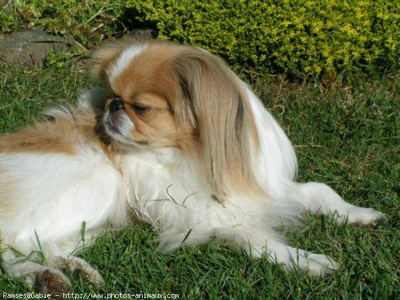

Predicted: japanese_spaniel
Probability: 0.7305790649618473


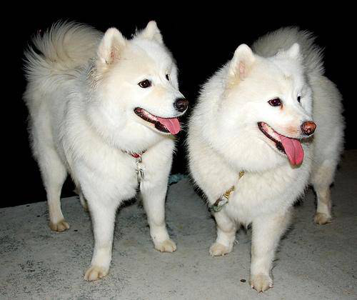

Predicted: samoyed
Probability: 0.7308547872049392


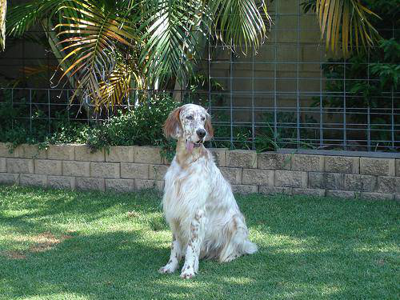

Predicted: english_setter
Probability: 0.7309797557987413


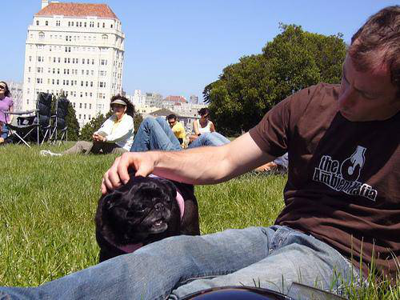

Predicted: pug
Probability: 0.7166642279095324


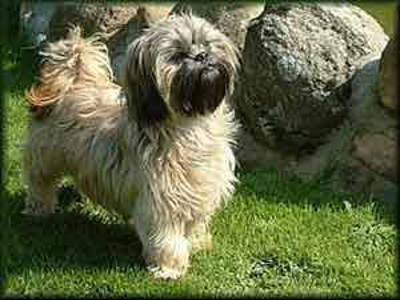

Predicted: lhasa
Probability: 0.7249322429113529


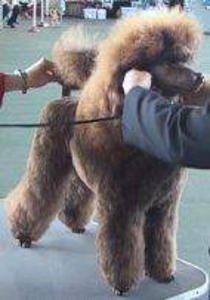

Predicted: irish_water_spaniel
Probability: 0.613983956915913


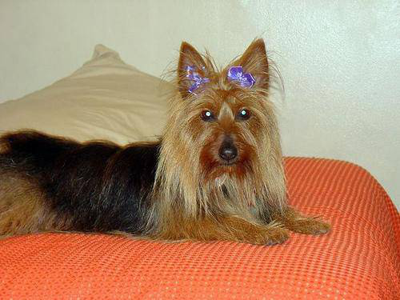

Predicted: australian_terrier
Probability: 0.7305308226306017


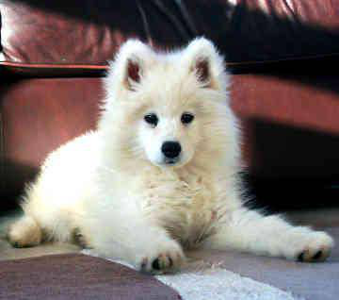

Predicted: samoyed
Probability: 0.7308409858032362


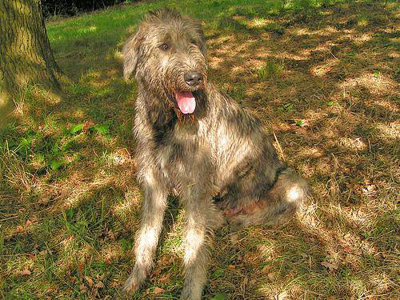

Predicted: irish_wolfhound
Probability: 0.7304466325198038


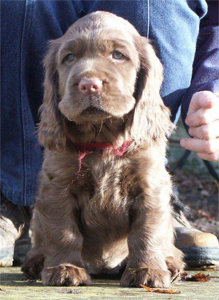

Predicted: sussex_spaniel
Probability: 0.7306632537840145


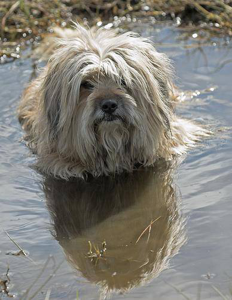

Predicted: tibetan_terrier
Probability: 0.7290916264120373


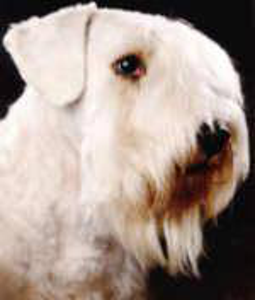

Predicted: sealyham_terrier
Probability: 0.7308908452297244


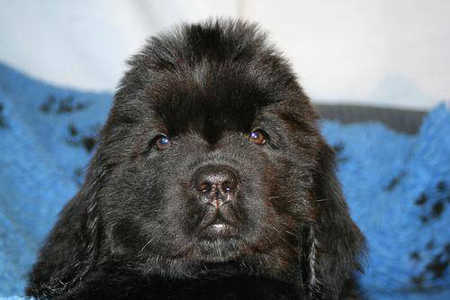

Predicted: newfoundland
Probability: 0.730440065425724


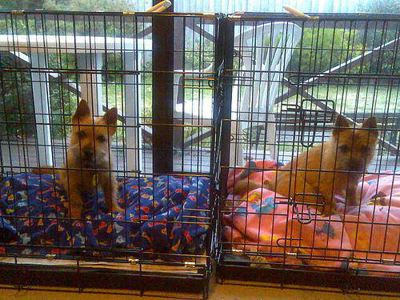

Predicted: norwich_terrier
Probability: 0.678450698495571


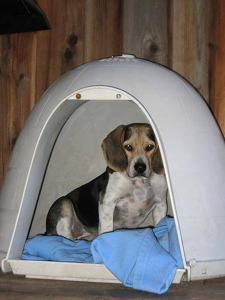

Predicted: beagle
Probability: 0.7294227669405354


In [10]:
from glob import glob
for fn in glob('data/test/*.jpg')[:15]:
    predict_breed(fn)